# Find precipitation events

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
impo
import datetime as dt

from ros_database.processing.extract_precip_events import find_events
from ros_database.filepath import SURFOBS_HOURLY_PATH
from ros_database.processing.surface import load_station_combined_data

pd.set_option('display.max_rows', 20)

PTYPES = ['UP','RA','FZRA','SOLID']

In [3]:
hourly = list(SURFOBS_HOURLY_PATH.glob("*.csv"))

In [4]:
df = load_station_combined_data(hourly[0])

In [5]:
df.head()

,station,t2m,d2m,relh,mslp,psurf,p01i,UP,RA,FZRA,SOLID,wspd,drct
datetime,,,,,,,,,,,,,
1988-01-05 14:00:00,PAFM,-7.1,-11.6,70.24,NaN,1017.6,NaN,NaN,NaN,NaN,NaN,3.09,90.0
1988-01-05 15:00:00,PAFM,-9.3,-13.8,69.77,NaN,1017.3,NaN,NaN,NaN,NaN,NaN,3.09,0.0
1988-01-05 16:00:00,PAFM,-11.6,-15.6,72.81,NaN,1017.3,NaN,NaN,NaN,NaN,NaN,2.58,340.0
1988-01-05 17:00:00,PAFM,-11.6,-16.0,69.85,NaN,1017.3,NaN,NaN,NaN,NaN,NaN,2.57,320.1
1988-01-05 18:00:00,PAFM,-11.6,-16.0,69.85,NaN,1016.9,NaN,NaN,NaN,NaN,NaN,2.06,349.9


## Some basic plotting

In [7]:
df.hist(column=["t2m", "d2m", "psurf", "p01i", "wspd", "drct"],
        layout=(2,3), sharey=True, backend="seaborn");

ValueError: Could not find plotting backend 'seaborn'. Ensure that you've installed the package providing the 'seaborn' entrypoint, or that the package has a top-level `.plot` method.

In [5]:
events = find_events(df)
events

,start,end,duration,RA,UP,FZRA,SOLID,t2m_mean,t2m_min,t2m_max
start,,,,,,,,,,
1988-02-13 21:00:00,1988-02-13 21:00:00,1988-02-13 21:00:00,1,False,False,False,True,-14.900000,-14.9,-14.9
1988-02-18 19:00:00,1988-02-18 19:00:00,1988-02-18 21:00:00,3,0,0,0,3,-24.533333,-25.5,-23.8
1988-02-18 23:00:00,1988-02-18 23:00:00,1988-02-18 23:00:00,1,False,False,False,True,-22.100000,-22.1,-22.1
1988-02-19 01:00:00,1988-02-19 01:00:00,1988-02-19 01:00:00,1,False,False,False,True,-21.600000,-21.6,-21.6
1988-02-19 03:00:00,1988-02-19 03:00:00,1988-02-19 03:00:00,1,False,False,False,True,-21.600000,-21.6,-21.6
...,...,...,...,...,...,...,...,...,...,...
2023-11-09 19:00:00,2023-11-09 19:00:00,2023-11-09 21:00:00,3,0,0,0,3,-2.400000,-2.8,-2.2
2023-11-10 02:00:00,2023-11-10 02:00:00,2023-11-10 23:00:00,22,0,0,0,22,-4.586364,-6.0,-2.6
2023-11-11 20:00:00,2023-11-11 20:00:00,2023-11-11 20:00:00,1,False,False,False,True,-15.600000,-15.6,-15.6


<Axes: title={'center': 'UP only'}, ylabel='Frequency'>

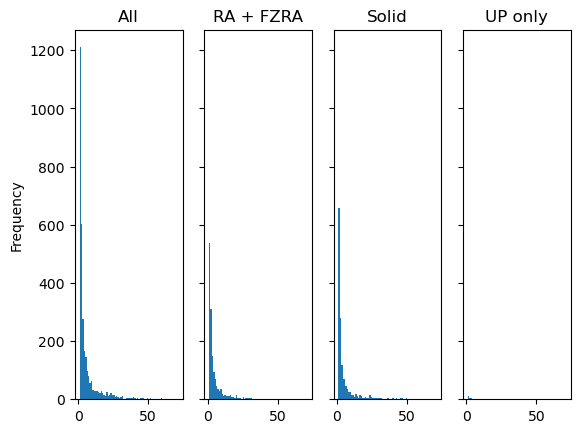

In [36]:
bins = np.arange(1,72)

fig, ax = plt.subplots(1, 4, sharey=True)
events['duration'].plot(kind='hist', ax=ax[0], bins=bins, title="All")

liquid = (events.RA > 0) | (events.FZRA > 0) & (events.SOLID == 0) & (events.UP == 0)
events[liquid]['duration'].plot(kind='hist', ax=ax[1], bins=bins, title="RA + FZRA", ylabel="")

solid = (events.RA == 0) & (events.FZRA == 0) & (events.SOLID > 0) & (events.UP == 0)
events[solid]['duration'].plot(kind='hist', ax=ax[2], bins=bins, title="Solid")

up_only = (events.RA == 0) & (events.FZRA == 0) & (events.SOLID == 0) & (events.UP > 0)
events[up_only]['duration'].plot(kind='hist', ax=ax[3], bins=bins, title="UP only")


In [33]:
test = pd.DataFrame(
        [
            [False, True, False, False],  # RA only
            [0, 2, 0, 1],                  # RA and SOLID only
            [False, False, False, True], # SOLID only
            [2, 0, 0, 0],
        ],
    columns=['UP','RA','FZRA','SOLID'],
)
test        

,UP,RA,FZRA,SOLID
0,False,True,False,False
1,0,2,0,1
2,False,False,False,True
3,2,0,0,0


In [34]:
def is_liquid(df):
    return (df.RA > 0) | (df.FZRA > 0) & (df.SOLID == 0) & (df.UP == 0)

def is_solid(df):
    return (df.RA == 0) & (df.FZRA == 0) & (df.SOLID > 0) & (df.UP == 0)

def is_up(df):
    return (df.RA == 0) & (df.FZRA == 0) & (df.SOLID == 0) & (df.UP > 0)

In [35]:
# Check liquid
pd.testing.assert_series_equal(is_liquid(test), pd.Series([True, True, False, False]),
                              check_index_type=False,)

pd.testing.assert_series_equal(is_solid(test), pd.Series([False, False, True, False]),
                              check_index_type=False,)

pd.testing.assert_series_equal(is_up(test), pd.Series([False, False, False, True]),
                              check_index_type=False,)

## Plot precipitation type and amount

In [86]:
import matplotlib.dates as mdates

def make_event_bars(df, y0=-0.05, height=0.05, color='0.7'):
    event_box = []
    for event in df.iterrows():
        x0 = mdates.date2num(event[1].start)
        x1 = mdates.date2num(event[1].end)
        width = x1 - x0
        if event[1].RA:
            color='crimson'
        else:
            color='0.7'
        event_box.append(Rectangle((x0, y0), width, height, facecolor=color, edgecolor=color))
    return PatchCollection(event_box, zorder=0, match_original=True)

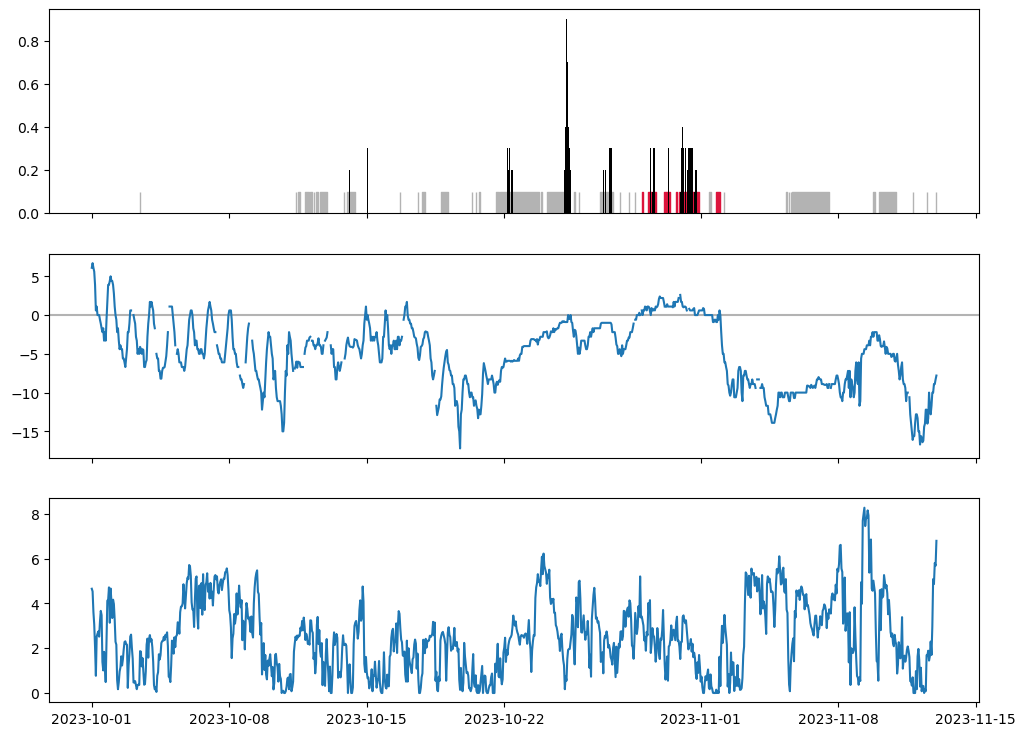

In [240]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

sub_df = df['2023-10-01':]
sub_events = events['2023-10-01':]

fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

width = dt.timedelta(hours=1)
ax[0].bar(sub_df.index, sub_df.p01i, width=width, color='k')
ax[0].add_collection(make_event_bars(sub_events, y0=0., height=0.1))
# [ax[0].axhline(-0.05, xmin=
               
ax[1].plot(sub_df.index, sub_df.t2m)
ax[1].axhline(0., c='0.7', zorder=0)

ax[2].plot(sub_df.index, sub_df.wspd)

In [92]:
sub_df.drop(['station', 'd2m', 'relh', 'mslp', 'psurf', 'drct'], axis=1)

,t2m,p01i,UP,RA,FZRA,SOLID,wspd,PRECIP,event
datetime,,,,,,,,,
2023-10-01 00:00:00,6.1,0.0,NaN,NaN,NaN,NaN,4.66,False,6269
2023-10-01 01:00:00,6.7,0.0,NaN,NaN,NaN,NaN,4.54,False,6269
2023-10-01 02:00:00,6.1,0.0,NaN,NaN,NaN,NaN,3.62,False,6269
2023-10-01 03:00:00,5.6,0.0,NaN,NaN,NaN,NaN,3.06,False,6269
2023-10-01 04:00:00,3.9,0.0,NaN,NaN,NaN,NaN,2.05,False,6269
2023-10-01 05:00:00,0.6,0.0,NaN,NaN,NaN,NaN,0.77,False,6269
2023-10-01 06:00:00,1.1,0.0,NaN,NaN,NaN,NaN,2.52,False,6269
2023-10-01 07:00:00,0.0,0.0,NaN,NaN,NaN,NaN,2.65,False,6269
2023-10-01 08:00:00,0.0,0.0,NaN,NaN,NaN,NaN,2.75,False,6269


## Find frequency of reported precipitation

In [95]:
for ptype in ["UP", "RA", "FZRA", "SOLID"]:
    print(f"{ptype:5s} and measured P:    {(df[ptype] & (df.p01i > 0)).sum()}")
    print(f"{ptype:5s} and no measured P: {(df[ptype] & (df.p01i == 0)).sum()}")

UP    and measured P:    172
UP    and no measured P: 615
RA    and measured P:    3061
RA    and no measured P: 2895
FZRA  and measured P:    0
FZRA  and no measured P: 0
SOLID and measured P:    541
SOLID and no measured P: 9575


<Axes: >

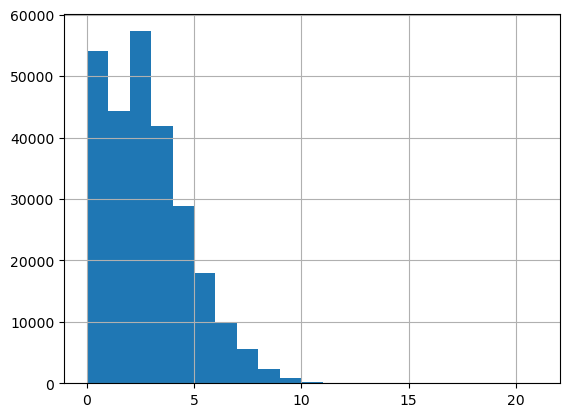

In [99]:
df.wspd.hist(bins=np.arange(0,22))

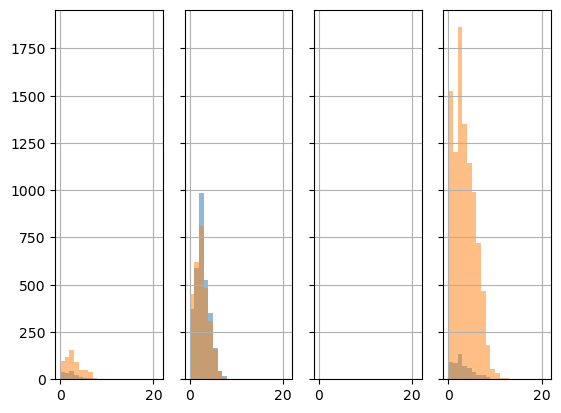

In [103]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
bins = np.arange(0,22)
for i, ptype in enumerate(["UP", "RA", "FZRA", "SOLID"]):
    df[df[ptype] & (df.p01i > 0)].wspd.hist(ax=ax[i], bins=bins, alpha=0.5)
    df[df[ptype] & (df.p01i == 0)].wspd.hist(ax=ax[i], bins=bins, alpha=0.5)
    

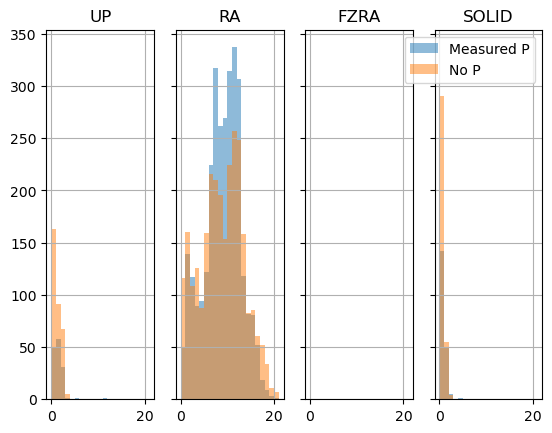

In [107]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
bins = np.arange(0,22)
for i, ptype in enumerate(["UP", "RA", "FZRA", "SOLID"]):
    df[df[ptype] & (df.p01i > 0)].t2m.hist(ax=ax[i], bins=bins, alpha=0.5, label="Measured P")
    df[df[ptype] & (df.p01i == 0)].t2m.hist(ax=ax[i], bins=bins, alpha=0.5, label="No P")
    ax[i].set_title(ptype)
    if i == 3:
        ax[i].legend()

## Find winter period

## Aggregate to daily for analysis

In [126]:
df.p01i.min()

0.0

In [133]:
df["1988-01-05":"1988-01-05 23"].p01i.sum()

0.0

In [177]:
nansum = lambda x: np.sum(x) if x.notnull().all() else np.nan
count_ptypes = "sum"

dfday = df.resample('D').agg(
    {
        "t2m": "mean", 
        "p01i": nansum,
        "RA": "any",
        "FZRA": "any",
        "UP": "any",
        "SOLID": "any",
    }
)
dfday

,t2m,p01i,RA,FZRA,UP,SOLID
datetime,,,,,,
1988-01-05,-10.325000,NaN,False,False,False,False
1988-01-06,-8.711111,NaN,False,False,False,False
1988-01-07,-6.633333,NaN,False,False,False,False
1988-01-08,-8.390909,NaN,False,False,False,False
1988-01-09,-10.280000,NaN,False,False,False,False
...,...,...,...,...,...,...
2023-11-09,-4.579167,0.0,False,False,False,True
2023-11-10,-4.479167,0.0,False,False,False,True
2023-11-11,-10.452174,NaN,False,False,False,True


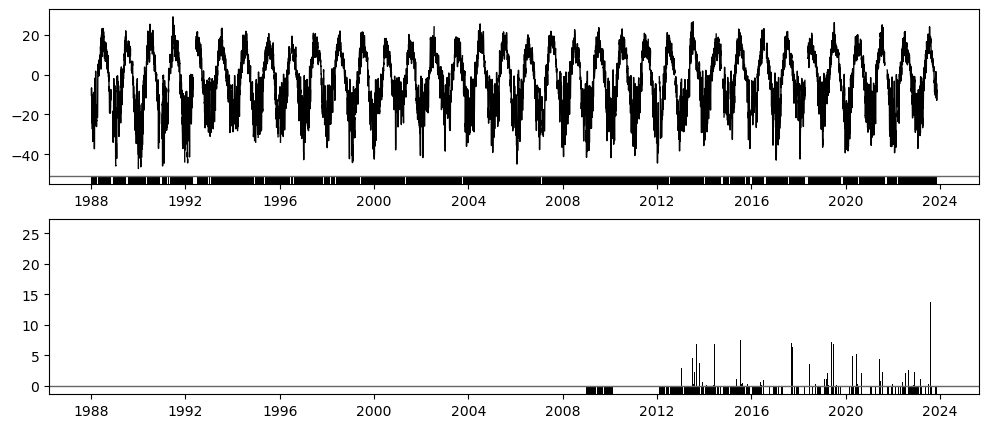

In [160]:
def add_valid_obs_bar(da, ax, axis_fraction=0.05, color='k'):
    y0, y1 = ax.get_ylim()
    baseline = y0
    yrange = y1 - y0
    yextra = (yrange * axis_fraction)
    y0 = baseline - yextra
    ylim = (y0, y1)

    ax.set_ylim(ylim)
    ax.axhline(baseline, color=color, lw=1)
    ax.bar(da.index, da.notnull() * -1 * yextra,
           bottom=baseline, width=width, color='k')
    

fig, ax = plt.subplots(2, 1, figsize=(12,5))

ax[0].plot(dfday.index, dfday.t2m, color='k', lw=1)
add_valid_obs_bar(dfday.t2m, ax[0], color='0.4')

width = dt.timedelta(days=1)
ax[1].bar(dfday.index, dfday.p01i, width=width, color='k')
add_valid_obs_bar(dfday.p01i, ax[1], color='0.4')

# Add PTYPE?, wspd

## Load Snow Cover

In [111]:
snowcover = pd.read_csv("ims.surface_values.stations.csv", index_col=0, parse_dates=True)
snowcover.head()

,PALP,PAFM,PAKP,PANC,PANV,PARC,PABR,PABE,PABT,PABV,...,ESNS,ESSA,ESNN,ESND,ESST,ESNU,ESCM,ESOW,ESPE,ESNV
time,,,,,,,,,,,,,,,,,,,,,
2004-02-25,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,2.0,1.0,4.0,4.0
2004-02-26,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
2004-02-27,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
2004-02-28,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
2004-02-29,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0


In [179]:
freq = lambda x: (x == 4).sum()/x.count()
ptype_freq = lambda x: x.sum()/x.count()

sog_freq = snowcover["PAFM"].groupby(snowcover.index.day_of_year).apply(freq)

Text(0.5, 0.98, 'PAFM')

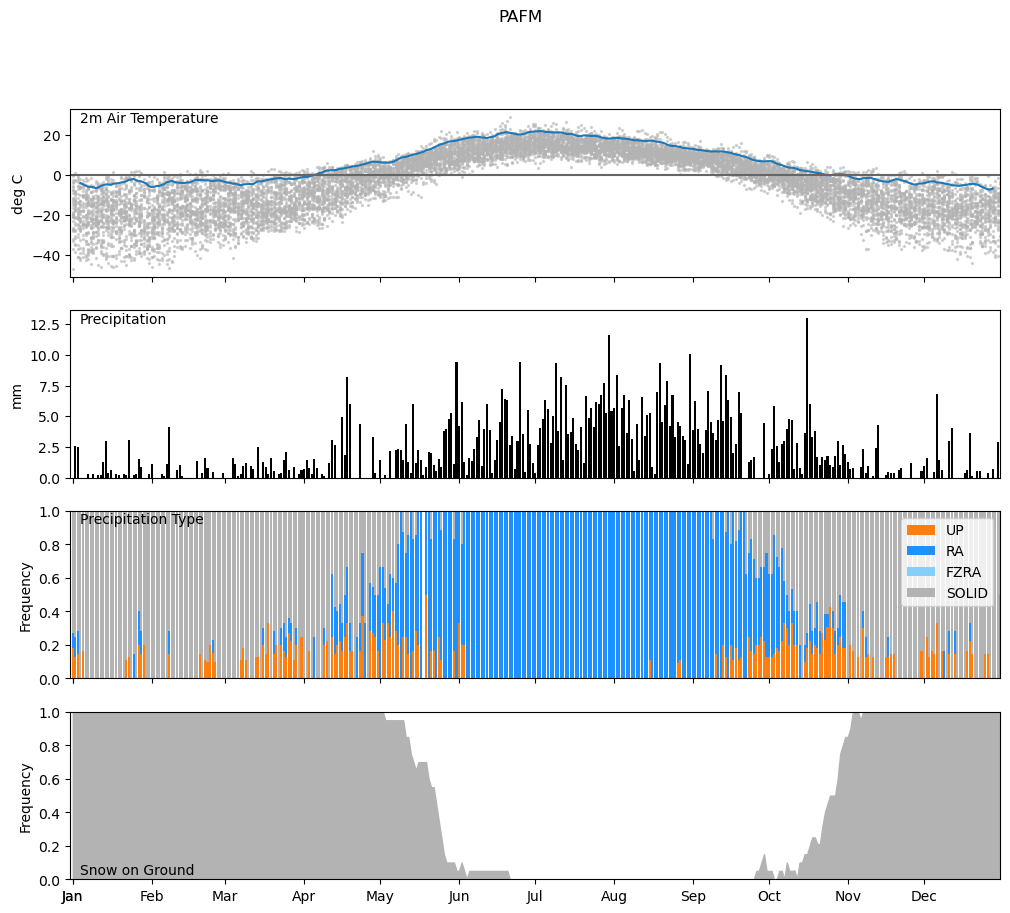

In [239]:
import matplotlib.pyplot as plt

# Calculate 95th percentile temperatures
t2m_95 = dfday.t2m.groupby(dfday.index.day_of_year).quantile(0.95).rolling(window=7, center=True).mean()
p01i_mean = dfday.p01i.where(dfday.p01i > 0).groupby(dfday.index.day_of_year).mean()
ptype_freq = dfday[PTYPES].groupby(dfday.index.day_of_year).apply(lambda x: x.sum() / x.sum().sum())  #sum()

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12,10))

ax[0].scatter(dfday.index.day_of_year, dfday.t2m, s=2, c='0.7', alpha=0.5)
ax[0].plot(t2m_95.index, t2m_95)
ax[0].axhline(0., c='0.4')
ax[0].set_ylabel("deg C")
ax[0].text(0.01, 0.99, "2m Air Temperature", va="top", transform=ax[0].transAxes)

ax[1].bar(p01i_mean.index, p01i_mean, color='k')
ax[1].set_ylabel("mm")
ax[1].text(0.01, 0.99, "Precipitation", va="top", transform=ax[1].transAxes)

bottom = 0
colors = ['tab:orange', 'dodgerblue', 'lightskyblue', '0.7'] 
for pf, color in zip(ptype_freq, colors):
    ax[2].bar(ptype_freq.index, ptype_freq[pf], label=pf, bottom=bottom, color=color)
    bottom += ptype_freq[pf]
# ax[2].plot(up_freq.index, up_freq, label="UP")
# ax[2].plot(fzra_freq.index, fzra_freq, label="FZRA")
# ax[2].plot(solid_freq.index, solid_freq, label="SOLID")
ax[2].set_ylabel("Frequency")
ax[2].text(0.01, 0.99, "Precipitation Type", va="top", transform=ax[2].transAxes)
ax[2].legend()

ax[3].fill_between(sog_freq.index, sog_freq, color='0.7')
ylim = ax[3].get_ylim()
ax[3].set_ylim(0., 1.)
ax[3].set_ylabel("Frequency")
ax[3].text(0.01, 0.01, "Snow on Ground", va="bottom", transform=ax[3].transAxes)
ax[3].set_xlim(0.,366.)

# Make xticks and labels
monticks, monlabels = zip(*[(d.day_of_year, d.month_name()[:3]) 
                          for d in pd.date_range('2024-01-01', '2025-01-01', freq='MS')])
list(monticks)[-1] = 366
ax[3].set_xticks(monticks, monlabels)

fig.suptitle("PAFM")

# Add months to xaxis
# Add PTYPES